In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import chi2, chisquare
from statsmodels.graphics.regressionplots import abline_plot
import scipy.stats as stats 
from sklearn.metrics import roc_curve, auc
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("dados_lista_2_multinominal-1.csv")
df.shape

(200, 14)

In [3]:
df.head()

,Unnamed: 0,id,female,ses,schtyp,prog,read,write,math,science,socst,honors,awards,cid
0,1,45,female,low,public,vocation,34,35,41,29,26,not enrolled,0,1
1,2,108,male,middle,public,general,34,33,41,36,36,not enrolled,0,1
2,3,15,male,high,public,vocation,39,39,44,26,42,not enrolled,0,1
3,4,67,male,low,public,vocation,37,37,42,33,32,not enrolled,0,1
4,5,153,male,middle,public,vocation,39,31,40,39,51,not enrolled,0,1


In [4]:
df.tail()

,Unnamed: 0,id,female,ses,schtyp,prog,read,write,math,science,socst,honors,awards,cid
195,196,100,female,high,public,academic,63,65,71,69,71,enrolled,5,20
196,197,143,male,middle,public,vocation,63,63,75,72,66,enrolled,4,20
197,198,68,male,middle,public,academic,73,67,71,63,66,enrolled,7,20
198,199,57,female,middle,public,academic,71,65,72,66,56,enrolled,5,20
199,200,132,male,middle,public,academic,73,62,73,69,66,enrolled,3,20


In [5]:
df.isnull().sum()

Unnamed: 0    0
id            0
female        0
ses           0
schtyp        0
prog          0
read          0
write         0
math          0
science       0
socst         0
honors        0
awards        0
cid           0
dtype: int64

In [6]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  200 non-null    int64 
 1   id          200 non-null    int64 
 2   female      200 non-null    object
 3   ses         200 non-null    object
 4   schtyp      200 non-null    object
 5   prog        200 non-null    object
 6   read        200 non-null    int64 
 7   write       200 non-null    int64 
 8   math        200 non-null    int64 
 9   science     200 non-null    int64 
 10  socst       200 non-null    int64 
 11  honors      200 non-null    object
 12  awards      200 non-null    int64 
 13  cid         200 non-null    int64 
dtypes: int64(9), object(5)
memory usage: 22.0+ KB


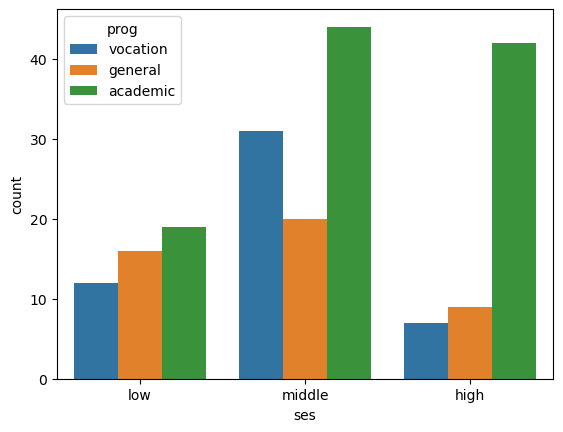

In [7]:
sns.countplot(data=df, x='ses', hue='prog');

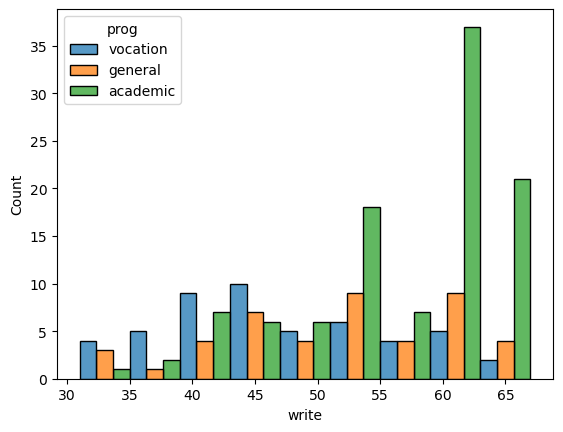

In [8]:
sns.histplot(data=df, x='write', hue='prog',  multiple="dodge");

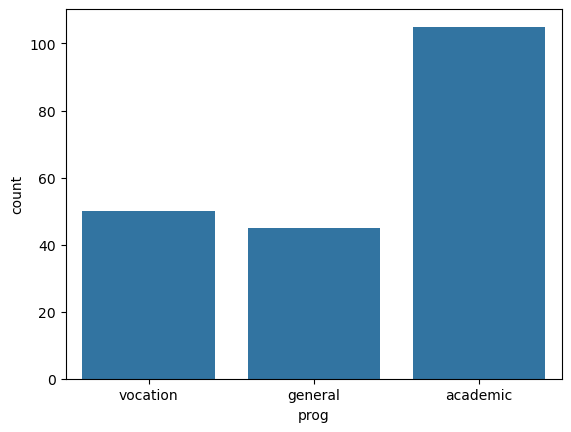

In [9]:
sns.countplot(data=df, x='prog');

In [10]:
# Ajustar variáveis target
df['prog_ajust'] = df['prog'].replace({'vocation':0, 'general':1, 'academic':2})

In [11]:
df['ses_middle'] = np.where(df['ses'] == 'middle',1,0)
df['ses_high'] = np.where(df['ses'] == 'high', 1, 0)

In [12]:
df_final = df[['write', 'prog_ajust', 'ses_middle', 'ses_high']]

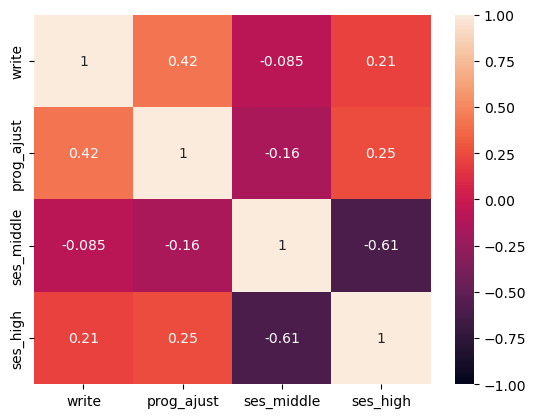

In [13]:
sns.heatmap(data=df_final.corr(), annot=True, vmax=1, vmin=-1) ;

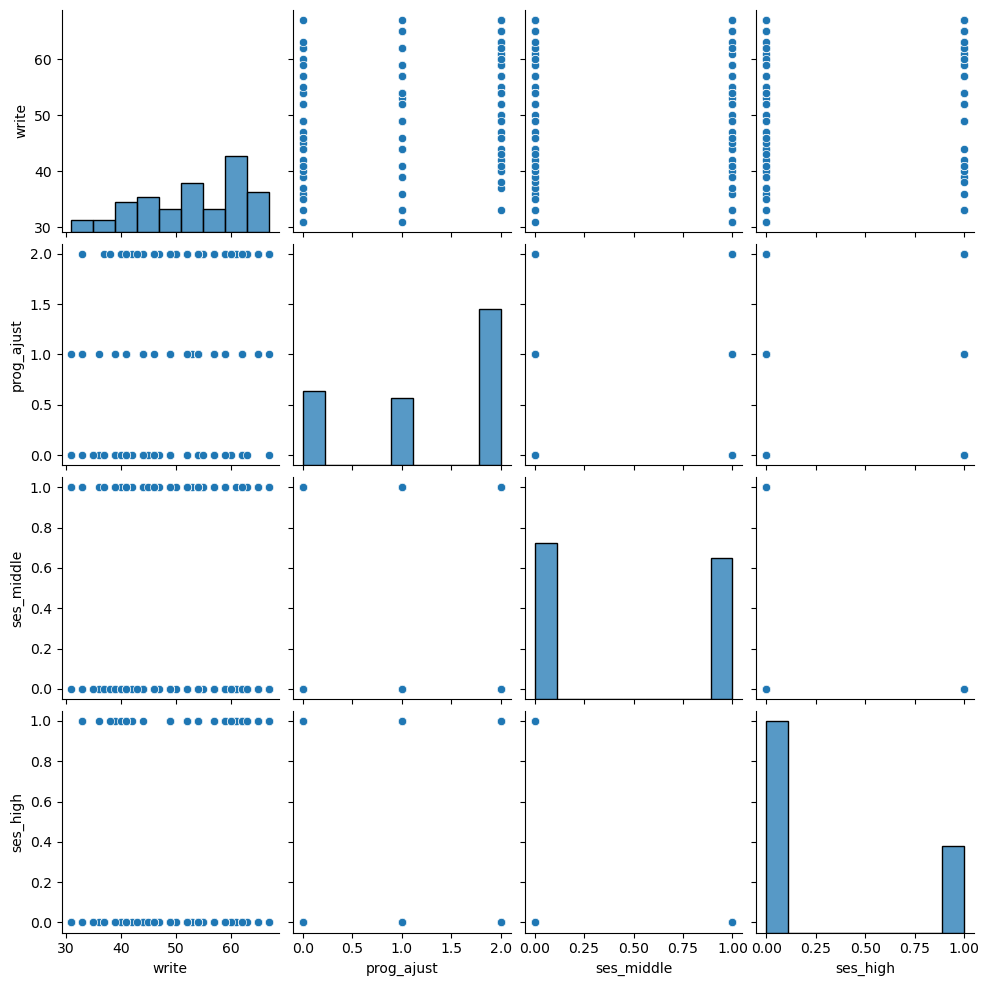

In [14]:
sns.pairplot(data=df_final);

### Desenvolver modelo regressão multinominal

In [15]:
#df_final.columns
x = df_final[['write', 'ses_middle', 'ses_high']]
y = df_final['prog_ajust']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [17]:
print("Tamanho do conjunto de treinamento (X_train):", X_train.shape)
print("Tamanho do conjunto de teste (X_test):", X_test.shape)
print("Tamanho do conjunto de treinamento (y_train):", y_train.shape)
print("Tamanho do conjunto de teste (y_test):", y_test.shape)

Tamanho do conjunto de treinamento (X_train): (140, 3)
Tamanho do conjunto de teste (X_test): (60, 3)
Tamanho do conjunto de treinamento (y_train): (140,)
Tamanho do conjunto de teste (y_test): (60,)


In [18]:
x_test = sm.add_constant(X_test)

In [19]:
modelo = sm.MNLogit(y_train, sm.add_constant(X_train)).fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.869688
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:             prog_ajust   No. Observations:                  140
Model:                        MNLogit   Df Residuals:                      132
Method:                           MLE   Df Model:                            6
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                  0.1393
Time:                        20:08:39   Log-Likelihood:                -121.76
converged:                       True   LL-Null:                       -141.46
Covariance Type:            nonrobust   LLR p-value:                 5.941e-07
prog_ajust=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.7827      1.423     -2.657      0.008      -6.573      -0.993
write            0.0706

In [20]:
models = []
residuals_pearson = []
residuals_deviance = []
valores_ajustados = []

for cls in range(2):
    y_binary = (y == cls).astype(int) 
    model = sm.GLM(y_binary, x, family=sm.families.Binomial())
    result = model.fit()
    models.append(result)
    
    # Calcular resíduos
    residuals_pearson.append(result.resid_pearson)
    residuals_deviance.append(result.resid_deviance)
    valores_ajustados.append(result.fittedvalues)

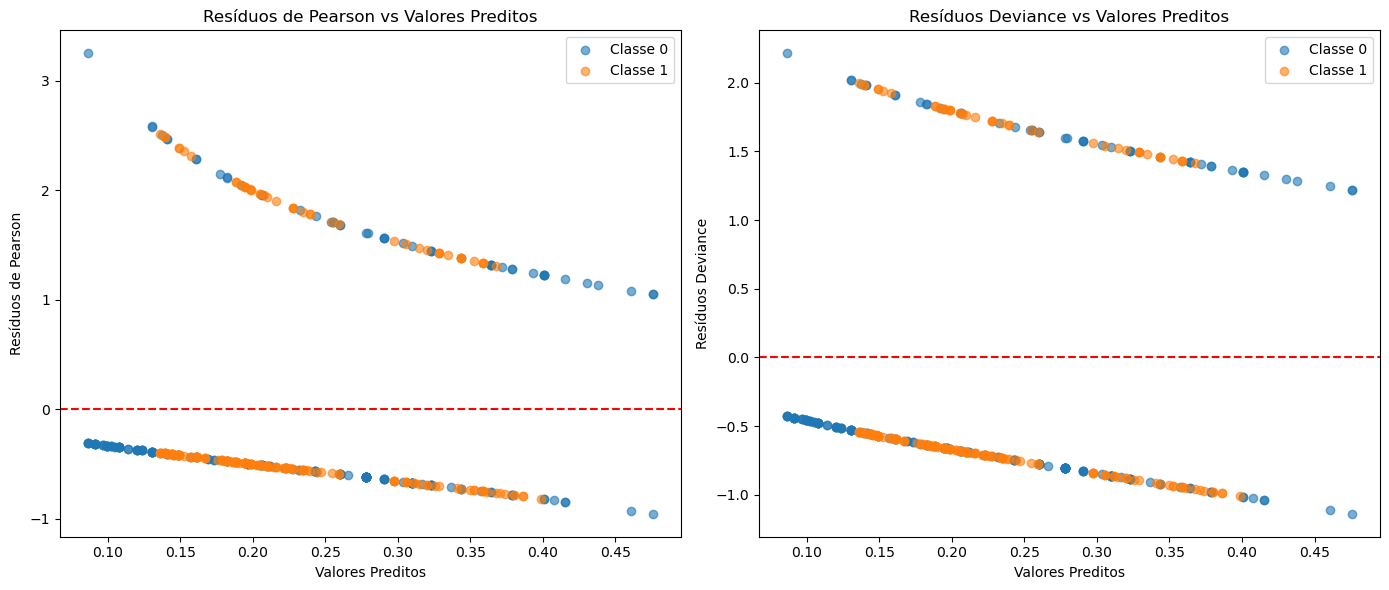

In [21]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for cls in range(2):
    plt.scatter(models[cls].fittedvalues, residuals_pearson[cls], label=f'Classe {cls}', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos de Pearson')
plt.title('Resíduos de Pearson vs Valores Preditos')
plt.legend()


plt.subplot(1, 2, 2)
for cls in range(2):
    plt.scatter(models[cls].fittedvalues, residuals_deviance[cls], label=f'Classe {cls}', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos Deviance')
plt.title('Resíduos Deviance vs Valores Preditos')
plt.legend()

plt.tight_layout()
plt.show()

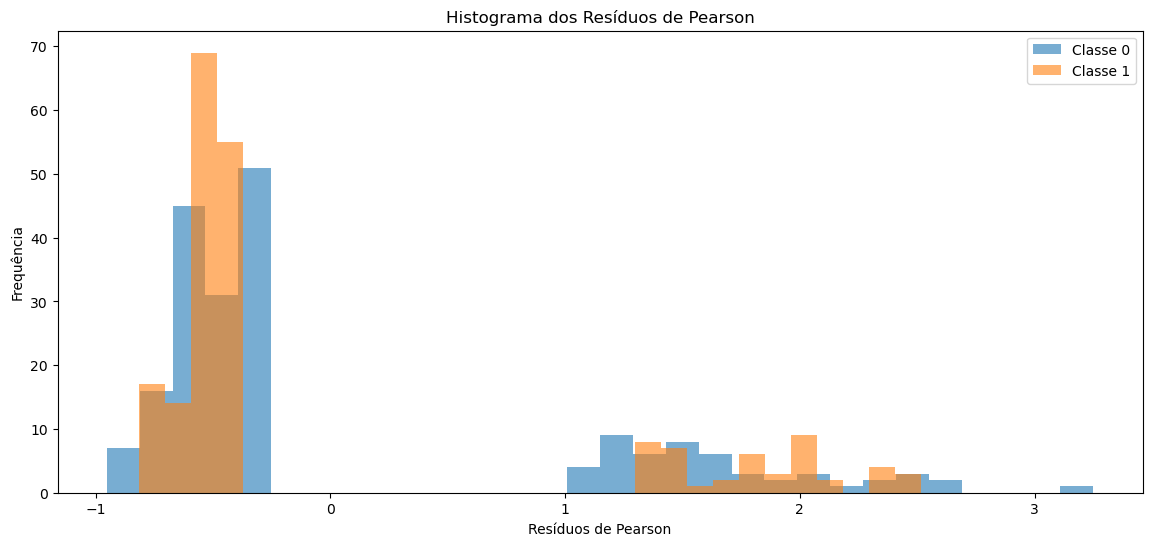

In [22]:
plt.figure(figsize=(14, 6))
for cls in range(2):
    plt.hist(residuals_pearson[cls], bins=30, alpha=0.6, label=f'Classe {cls}')
plt.xlabel('Resíduos de Pearson')
plt.ylabel('Frequência')
plt.title('Histograma dos Resíduos de Pearson')
plt.legend()
plt.show()

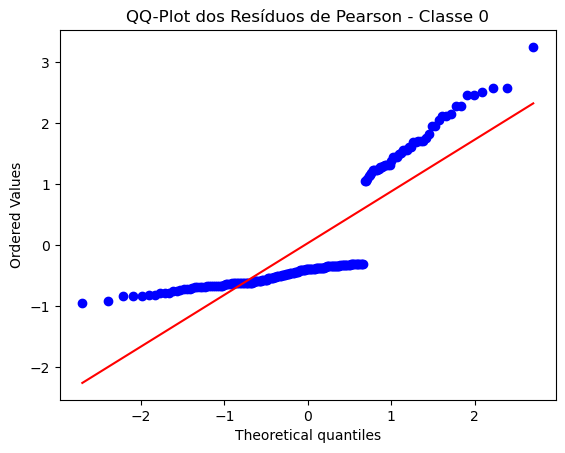

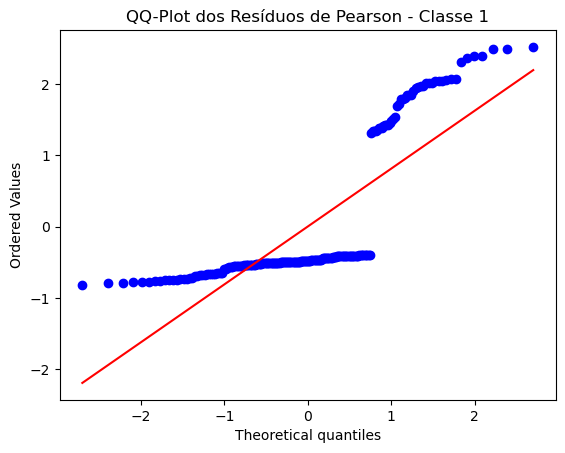

In [23]:
for cls in range(2):
    stats.probplot(residuals_pearson[cls], dist="norm", plot=plt)
    plt.title(f'QQ-Plot dos Resíduos de Pearson - Classe {cls}')
    plt.show()

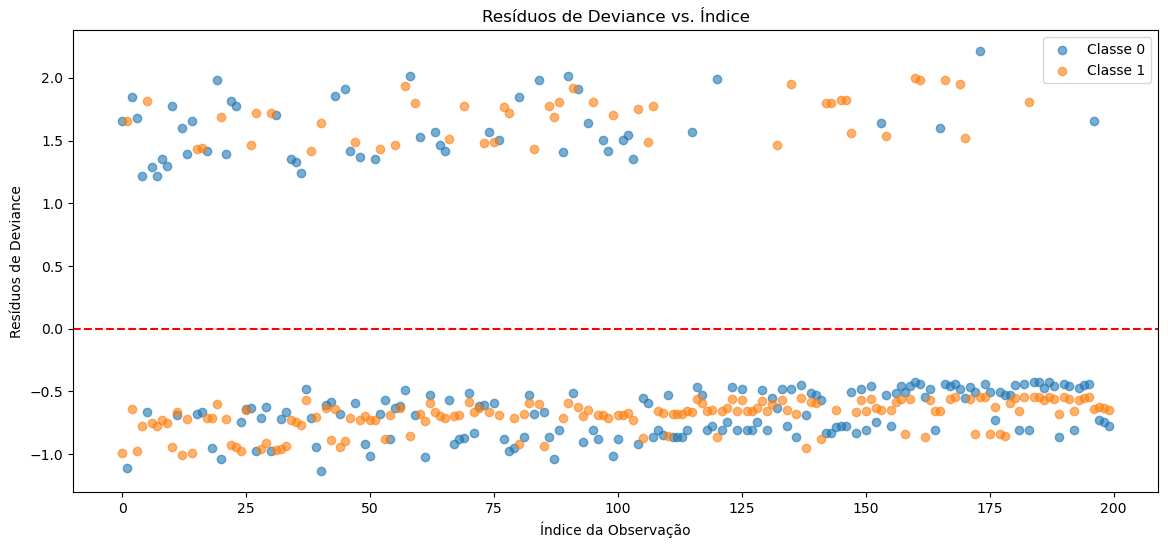

In [24]:
plt.figure(figsize=(14, 6))
for cls in range(2):
    plt.scatter(range(len(residuals_deviance[cls])), residuals_deviance[cls], label=f'Classe {cls}', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Índice da Observação')
plt.ylabel('Resíduos de Deviance')
plt.title('Resíduos de Deviance vs. Índice')
plt.legend()
plt.show()

In [25]:
y_pred_train = modelo.predict()
y_pred_test = modelo.predict(x_test).values

In [26]:
#y_pred_test

### Deviance Residuals

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   A deviance total é comparada com uma distribuição qui-quadrado com $n - p$ graus de liberdade, onde $n$ é o número de observações e $p$ é o número de parâmetros no modelo.

-   **Aceitação de** $H_0$: Se o valor $p$ calculado a partir da deviance é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.


In [27]:
def residuos_deviance(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  
    deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))
    deviance_residuals[np.isnan(deviance_residuals)] = 0  
    return np.sum(deviance_residuals)  

In [28]:
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

In [29]:
deviances_por_classe = []

In [30]:
np.sort(y_train.unique())

array([0, 1, 2], dtype=int64)

In [31]:
print("\n--- Deviance e p-valor por modelo ---")
# Calcular deviance e p-valor separadamente para cada modelo gerado
for i in range(y_train_onehot.shape[1]):  # Garantindo que os índices sejam válidos
    deviance_classe = residuos_deviance(y_train_onehot[:, i], y_pred_train[:, i])
    p_value_classe = chi2.sf(deviance_classe, modelo.df_resid)  # Cálculo do p-valor
    
    deviances_por_classe.append(deviance_classe)
    classe = np.sort(y_train.unique())[i]  # Pegar o rótulo correto da classe
    print(f"Classe: {classe} | Deviance: {deviance_classe:.4f} | p-value: {p_value_classe:.4f}")


--- Deviance e p-valor por modelo ---
Classe: 0 | Deviance: 75.0942 | p-value: 1.0000
Classe: 1 | Deviance: 90.6796 | p-value: 0.9977
Classe: 2 | Deviance: 77.7388 | p-value: 1.0000


C:\Users\gabri\AppData\Local\Temp\ipykernel_7880\663908847.py:3: RuntimeWarning: divide by zero encountered in log
  deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))
C:\Users\gabri\AppData\Local\Temp\ipykernel_7880\663908847.py:3: RuntimeWarning: invalid value encountered in multiply
  deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))


## Testes de adequação do modelo

### 1. Pearson Chi-Square Test

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste qui-quadrado de Pearson, que segue uma distribuição qui-quadrado com $n - p$ graus de liberdade.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [32]:
def residuos_pearson(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Evitar divisão por zero
    return (y_true - y_pred) / np.sqrt(y_pred * (1 - y_pred))

In [33]:
chi2_por_classe = []

print("\n--- Teste Qui-Quadrado de Pearson por Modelo ---")
for i in range(y_train_onehot.shape[1]):  # Garantir que os índices sejam compatíveis
    residuos_pearson_val = residuos_pearson(y_train_onehot[:, i], y_pred_train[:, i])
    chi2_classe = np.sum(residuos_pearson_val ** 2)  # Calcular qui-quadrado
    p_value_classe = round(chi2.sf(chi2_classe, modelo.df_resid), 4)   # Calcular p-valor
    
    chi2_por_classe.append(chi2_classe)
    
    classe =  np.sort(y_train.unique())[i]  # Pegar o rótulo correto da classe
    print(f"Classe: {classe} | Chi2: {chi2_classe:.4f} | p-value: {p_value_classe:.4f}")


--- Teste Qui-Quadrado de Pearson por Modelo ---
Classe: 0 | Chi2: 124.9031 | p-value: 0.6568
Classe: 1 | Chi2: 149.1828 | p-value: 0.1456
Classe: 2 | Chi2: 136.8033 | p-value: 0.3696


### Teste de Hosmer-Lemeshow

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados (não há diferença significativa entre as frequências observadas e esperadas).

-   $H_a$: O modelo não ajusta bem os dados (há diferença significativa entre as frequências observadas e esperadas).

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste de Hosmer-Lemeshow, que segue uma distribuição qui-quadrado com $g - 2$ graus de liberdade, onde $g$ é o número de grupos.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que o nível de significância $\alpha$ (geralmente 0.05), aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [34]:
def hosmer_lemeshow_test(y_true, y_pred, g=10):
    # Garantir que y_true e y_pred tenham pelo menos duas dimensões
    y_true = np.array(y_true).reshape(-1, 1)
    y_pred = np.array(y_pred).reshape(-1, 1)

    # Criar dataframe para o teste
    data = pd.DataFrame({'observed': y_true.ravel(), 'predicted': y_pred.ravel()})

    # Criar grupos baseados nas previsões
    data['group'] = pd.qcut(data['predicted'], g, duplicates='drop')
    grouped = data.groupby('group')

    # Calcular observados e esperados
    observed = grouped['observed'].sum()
    expected = grouped['predicted'].sum()

    # Evitar divisão por zero
    expected = np.clip(expected, 1e-10, None)

    # Calcular estatística do teste
    hl_stat = ((observed - expected) ** 2 / (expected * (1 - expected / grouped.size()))).sum()
    hl_p_value = round(chi2.sf(hl_stat, g - 2), 4)  # Arredondar p-valor para 4 casas decimais
    
    return hl_stat, hl_p_value

In [35]:
hl_por_classe = []

print("\n--- Teste de Hosmer-Lemeshow por Modelo ---")
for i in range(y_train_onehot.shape[1]):  # Garantir que os índices estejam corretos
    hl_stat, p_value = hosmer_lemeshow_test(y_train_onehot[:, i], y_pred_train[:, i])
    hl_por_classe.append(hl_stat)
    
    classe = np.sort(y_train.unique())[i]  # Pegar rótulo da classe
    print(f"Classe: {classe} | HL-Stat: {hl_stat:.4f} | p-value: {p_value:.4f}")


--- Teste de Hosmer-Lemeshow por Modelo ---
Classe: 0 | HL-Stat: 7.7086 | p-value: 0.4624
Classe: 1 | HL-Stat: 11.9256 | p-value: 0.1546
Classe: 2 | HL-Stat: 7.4487 | p-value: 0.4891


C:\Users\gabri\AppData\Local\Temp\ipykernel_7880\3123362765.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('group')
C:\Users\gabri\AppData\Local\Temp\ipykernel_7880\3123362765.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('group')
C:\Users\gabri\AppData\Local\Temp\ipykernel_7880\3123362765.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupb

### **Teste da Razão de Verossimilhança (Likelihood Ratio Test - LR Test)**  
O **Teste da Razão de Verossimilhança (LR Test)** é um teste estatístico utilizado para comparar a qualidade do ajuste de dois modelos estatísticos, um deles sendo um modelo **restrito (nulo)** e o outro um modelo **completo (alternativo)**. Ele avalia se a inclusão de variáveis explicativas melhora significativamente a explicação da variável resposta.
### **Hipótese Testada:**
-   $H_0$: O modelo **restrito** (sem preditores) é tão bom quanto o modelo **completo** (com preditores), ou seja, **as variáveis independentes não melhoram significativamente o ajuste**.
-   $H_a$: O modelo **completo** é significativamente melhor que o modelo **restrito**, ou seja, **as variáveis independentes contribuem para explicar a variável resposta**.
### **Condição de Aceitação/Rejeição:**
- **Aceitação de** $H_0$ (não há evidência suficiente para dizer que o modelo completo é melhor): Se o valor $p$ for **maior** que o nível de significância $\alpha$ (geralmente 0.05), não há diferença estatisticamente significativa entre os modelos, indicando que as variáveis explicativas **não melhoram significativamente o modelo**.
- **Rejeição de** $H_a$ (o modelo completo é significativamente melhor): Se o valor $p$ for **menor** que $\alpha$, então rejeitamos $H_0$, sugerindo que as variáveis independentes **melhoram significativamente a explicação da variável resposta**.
### **Interpretação dos Resultados**
- **Se o valor-p for pequeno (< 0.05)**, há evidências de que o modelo com variáveis preditoras se ajusta melhor aos dados do que o modelo nulo.
- **Se o valor-p for grande (> 0.05)**, o modelo completo não se ajusta significativamente melhor do que o modelo sem preditores, indicando que as variáveis explicativas podem não ser úteis.



In [36]:
print("\n--- Teste de Razão de Verossimilhança (LR) por Modelo ---")

lrt_por_classe = []  # Lista para armazenar os resultados

# Obter rótulos das classes corretamente
rótulos_classes = np.unique(y_train)  # Obtém os rótulos reais das classes

for i in range(len(rótulos_classes)):  # Itera sobre as classes presentes no y_train
    ll_model = modelo.llf  # Log-Likelihood do modelo ajustado
    ll_null = modelo.llnull  # Log-Likelihood do modelo nulo (sem preditores)
    
    lrt_statistic = 2 * (ll_model - ll_null)  # Estatística do teste LR
    lrt_df = modelo.df_model  # Graus de liberdade
    lrt_p_value = round(1 - stats.chi2.cdf(lrt_statistic, lrt_df), 4)  # P-valor arredondado

    classe_real = rótulos_classes[i]  # Pegar rótulo da classe

    lrt_por_classe.append((classe_real, lrt_statistic, lrt_df, lrt_p_value))

    # Exibir resultados por classe
    print(f"\nClasse: {classe_real}")
    print(f"Estatística de teste: {lrt_statistic:.4f}")
    print(f"Graus de liberdade: {lrt_df}")
    print(f"Valor p: {lrt_p_value:.4f}")


--- Teste de Razão de Verossimilhança (LR) por Modelo ---

Classe: 0
Estatística de teste: 39.4127
Graus de liberdade: 6.0
Valor p: 0.0000

Classe: 1
Estatística de teste: 39.4127
Graus de liberdade: 6.0
Valor p: 0.0000

Classe: 2
Estatística de teste: 39.4127
Graus de liberdade: 6.0
Valor p: 0.0000


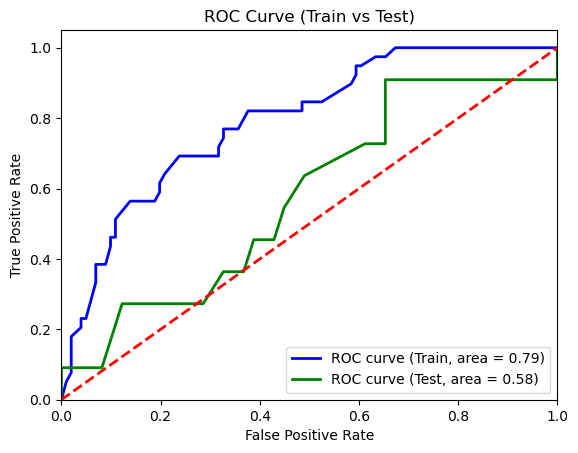

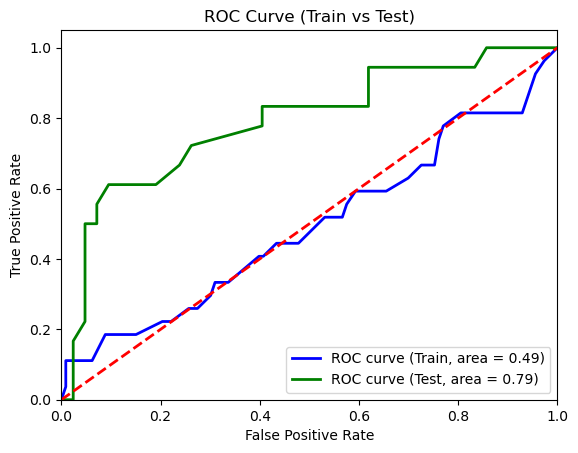

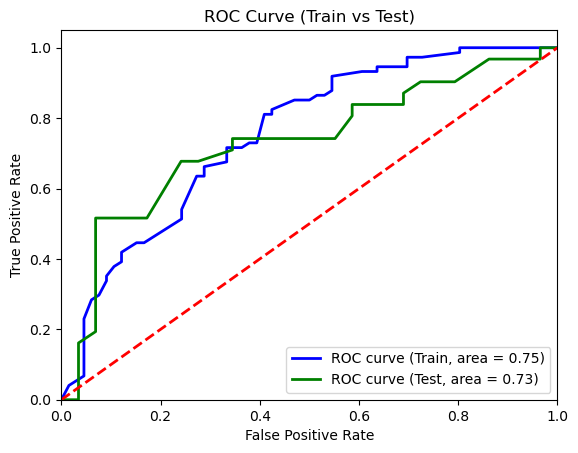

In [37]:
for i,j in zip(range(y_train_onehot.shape[1]), range(y_test_onehot.shape[1])):  
    fpr_train, tpr_train, _ = roc_curve(y_train_onehot[:, i], y_pred_train[:, i])
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, _ = roc_curve(y_test_onehot[:, j], y_pred_test[:, j])
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Pegar rótulo real da classe
    classe_real = rótulos_classes[i]  
    
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (Train, area = %0.2f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (Test, area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Train vs Test)')
    plt.legend(loc="lower right")
    plt.show()

In [38]:
coeficientes = modelo.params
print(coeficientes)

                   0         1
const      -3.782735 -5.393528
write       0.070636  0.114959
ses_middle -0.283073 -0.279706
ses_high    0.809699  1.458822


In [39]:
odds_ratio = np.exp(coeficientes)
print(odds_ratio)

                   0         1
const       0.022760  0.004546
write       1.073190  1.121828
ses_middle  0.753465  0.756006
ses_high    2.247232  4.300890


In [40]:
ic = modelo.conf_int()

ic_odds_ratio = np.exp(ic)
print(ic_odds_ratio)

                          lower      upper
prog_ajust                                
1          const       0.001398   0.370547
           write       1.015863   1.133753
           ses_middle  0.225781   2.514431
           ses_high    0.451325  11.189398
2          const       0.000347   0.059499
           write       1.067147   1.179310
           ses_middle  0.259690   2.200871
           ses_high    1.038046  17.819686


####  Analise do Odds Ratio (razão de chances) Modelo 1
* Para cada aumento de 1 unidade em write, as chances de estar no modelo 1 (em vez do modelo de referência) aumentam em 7.32%
* Indivíduos com ses_middle têm 24.65% menos chances de estar no modelo 1 (em vez do modelo de referência)
* Indivíduos com ses_high têm 124.72% mais chances de estar no modelo 1 (em vez do modelo de referência)

####  Analise do Odds Ratio (razão de chances) Modelo 2
* Para cada aumento de 1 unidade em write, as chances de estar no modelo 1 (em vez do modelo de referência) aumentam em 12.18%.
* Indivíduos com ses_middle têm 24.40% menos chances de estar no modelo 1 (em vez do modelo de referência).
* Indivíduos com ses_high têm 330.09% mais chances de estar no modelo 1 (em vez do modelo de referência)